#Review eb: Modelle trainieren

Ganzer Graph
- Event-basiert Instanzen


Präfixe:
- Event-basiert Instanzen
- Für jedes Bucket wird ein eigenes Model trainier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
# Hauptordner-Pfad
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM"

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [3]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2


In [4]:
%%capture
!pip install dive-into-graphs

In [5]:
%%capture
!pip install pm4py

In [6]:
import torch
import joblib
import random
from torch_geometric.data import DataLoader


from models.gcn3_neu import *
from train_gcn import Train_GCN, train_model, create_splitted_dataloader

# Module für das Preprocessing der verwendeten Datensätze
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *

In [7]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Datensatz laden

In [8]:
dataset_name = "review_all_events_f5_ohe_2_prefix" # "loan_sn_f2_ohe_wEvents_4"
dataset_list_review = torch.load(path / str("datasets/dataset_"+ dataset_name))
feature_list_review  = joblib.load("datasets/encoder_" + dataset_name + ".joblib")


## Modelle initialisieren

In [9]:
def instantiate_model(hidden_channel, num_feature, num_layer):
  # GCN initialisieren
  # Model Variablen 
  input_dim = num_feature
  gcn_model = GCN3(hidden_channel, input_dim, num_layer).to(device)
  return gcn_model

## Parameter Tuning

In [10]:
from utilities_parameter_tuning import save_plots, save_hyperparam, create_run, run_tuning

In [11]:
batch_size = 100
num_layer = 3
hidden_channel = 100

### Gesamter Graph

In [12]:
dataset = dataset_list_review[0]

<IPython.core.display.Javascript object>

-----------------lr: 0.05 ---------------------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_graph/run_1
save Hyperparameter
Epoch: 001, Train Acc: 0.7580, Validation Acc: 0.7655, Loss Training: 0.4687, Loss Validation: 0.4587
Epoch: 002, Train Acc: 0.7870, Validation Acc: 0.7885, Loss Training: 0.4250, Loss Validation: 0.4141
Epoch: 003, Train Acc: 0.7973, Validation Acc: 0.7990, Loss Training: 0.3553, Loss Validation: 0.3543
Epoch: 004, Train Acc: 0.8006, Validation Acc: 0.8005, Loss Training: 0.3513, Loss Validation: 0.3496
Epoch: 005, Train Acc: 0.8303, Validation Acc: 0.8230, Loss Training: 0.3820, Loss Validation: 0.3736
Epoch: 006, Train Acc: 0.7713, Validation Acc: 0.7795, Loss Training: 0.3637, Loss Validation: 0.3514
Epoch: 007, Train Acc: 0.8299, Validation Acc: 0.8320, Loss Training: 0.3328, Loss Validation: 0.3269
Epoch: 008, Train Acc: 0.8486, Validation Acc: 0.8405, Loss Training: 0.3374, Loss Validation: 0.331

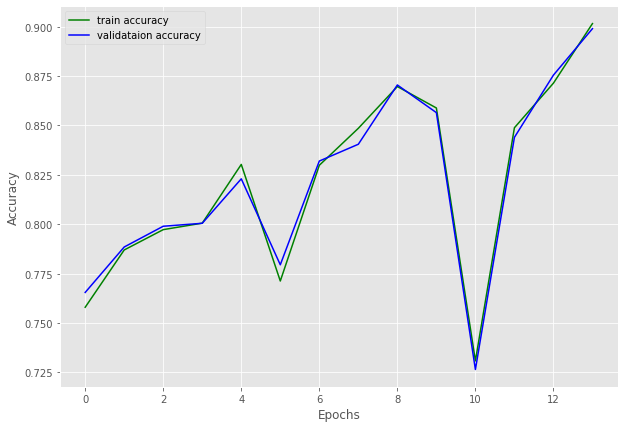

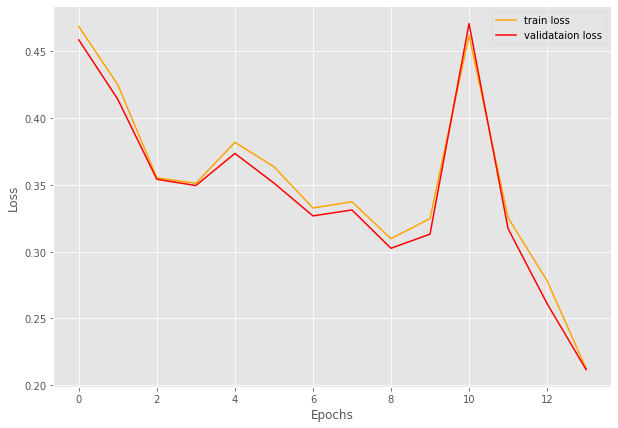

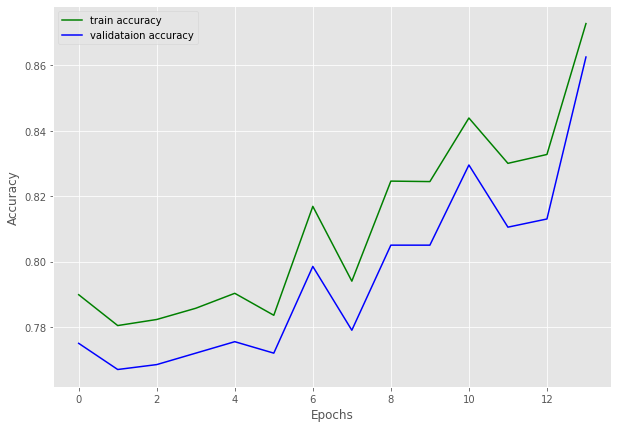

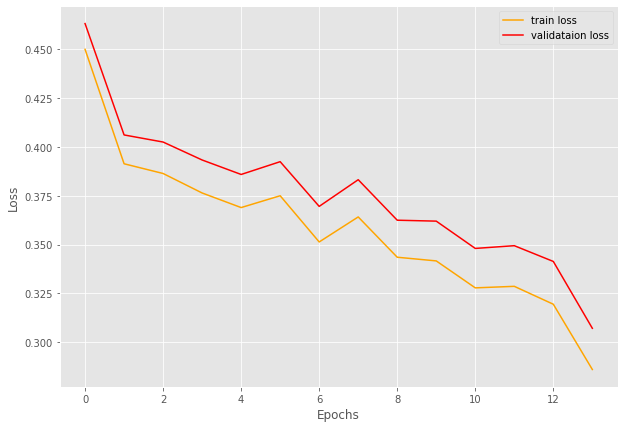

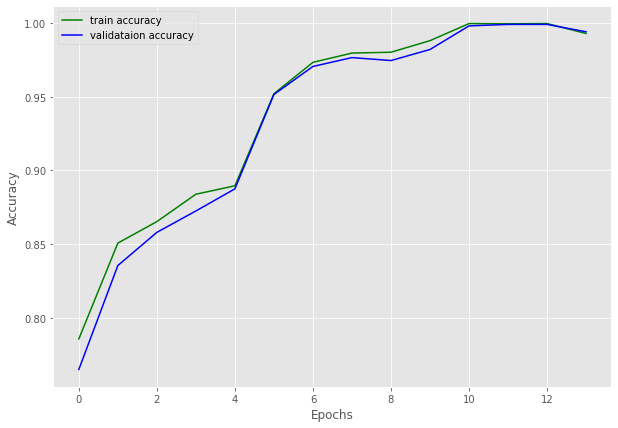

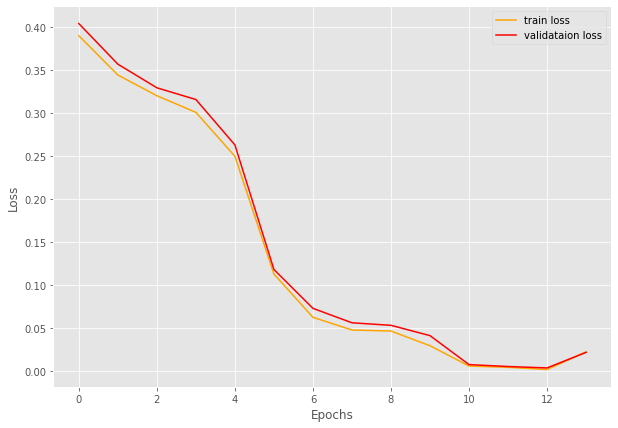

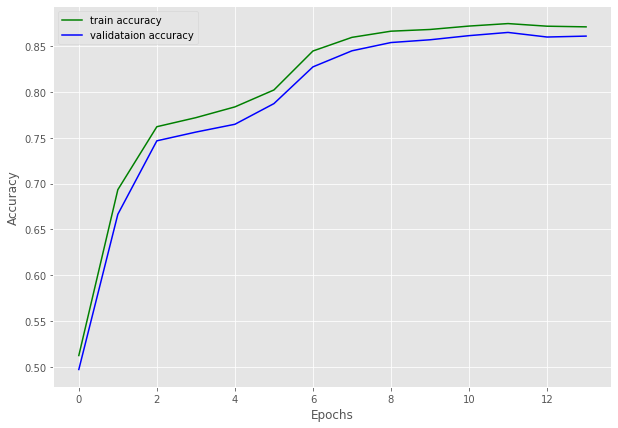

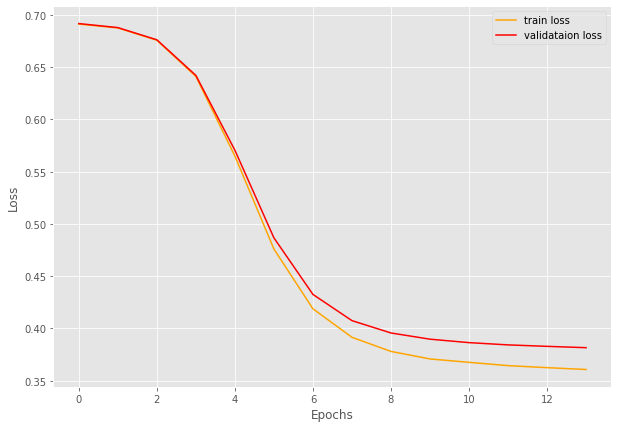

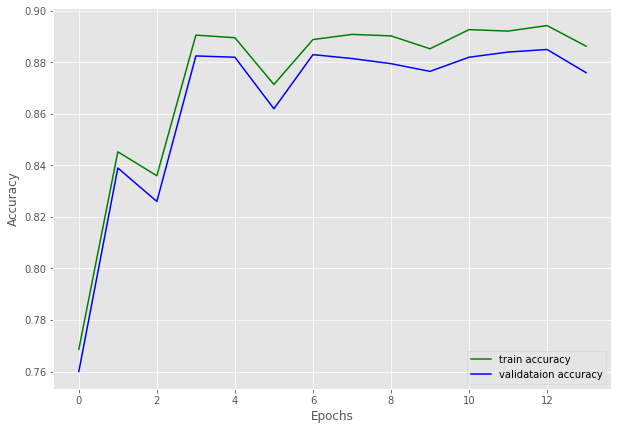

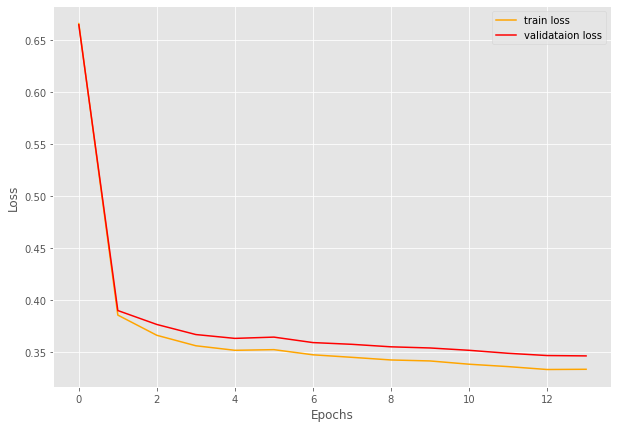

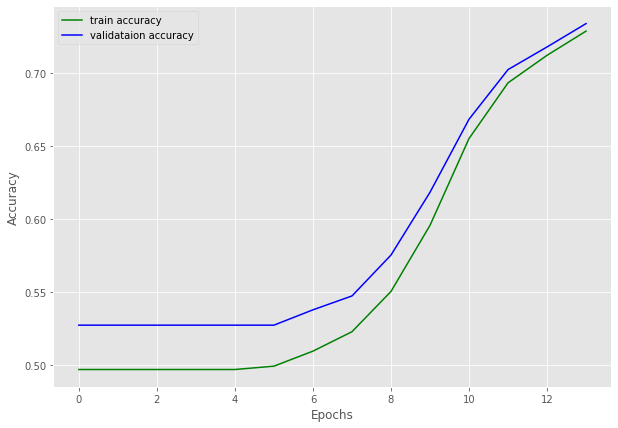

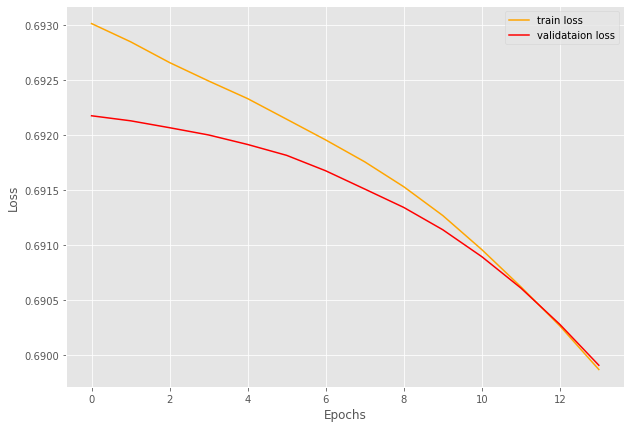

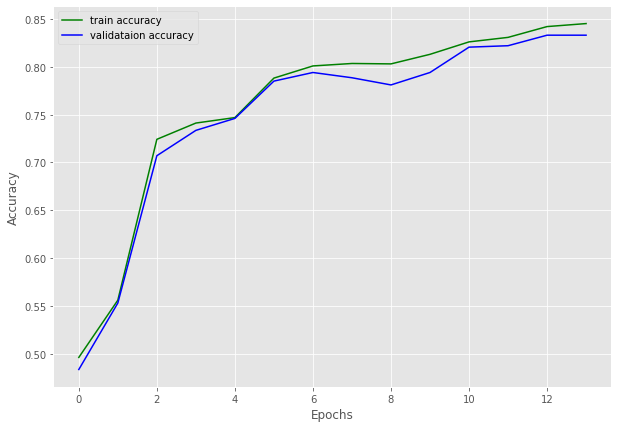

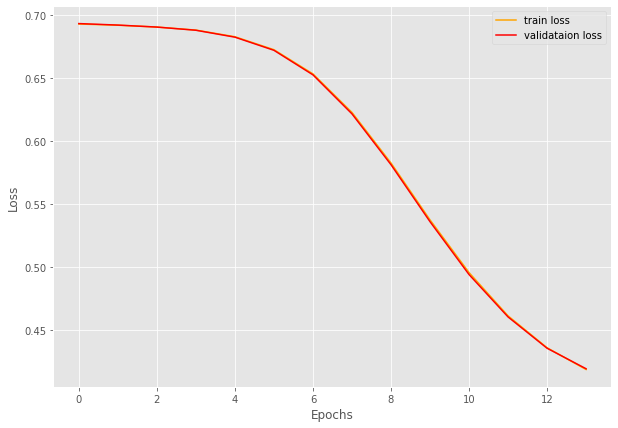

In [15]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

for lr in [0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00001, 0.00005]:
  print(f"-----------------lr: {lr} ---------------------------")
  # Variablen besetzen
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)
  #print(f"Feature-Anzahl: {num_feature}")

  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)  

  # tuning
  param = {"lr": lr, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_graph", gcn_model, device, train_loader, val_loader, test_loader)

### Präfixe

In [ ]:
# Ganzer Graph wird seperat trainiert
dataset_list_review.pop(0)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_1
save Hyperparameter
Epoch: 001, Train Acc: 0.6263, Validation Acc: 0.6085, Loss Training: 0.6463, Loss Validation: 0.6586
Epoch: 002, Train Acc: 0.6553, Validation Acc: 0.6465, Loss Training: 0.6233, Loss Validation: 0.6308
Epoch: 003, Train Acc: 0.6646, Validation Acc: 0.6405, Loss Training: 0.6046, Loss Validation: 0.6181
Epoch: 004, Train Acc: 0.6641, Validation Acc: 0.6520, Loss Training: 0.6046, Loss Validation: 0.6166
Epoch: 005, Train Acc: 0.6649, Validation Acc: 0.6550, Loss Training: 0.6133, Loss Validation: 0.6235
Epoch: 006, Train Acc: 0.6644, Validation Acc: 0.6365, Loss Training: 0.6083, Loss Validation: 0.6196
Epoch: 007, Train Acc: 0.6620, Validation Acc: 0.6460, Loss Training: 0.5989, Loss Validation: 0.6140
Epoch: 008, Train Acc: 0.6649, Validation Acc: 0.6550, Loss Training: 0.6068, Loss Validation: 0.6178
Epoch: 009, Train A

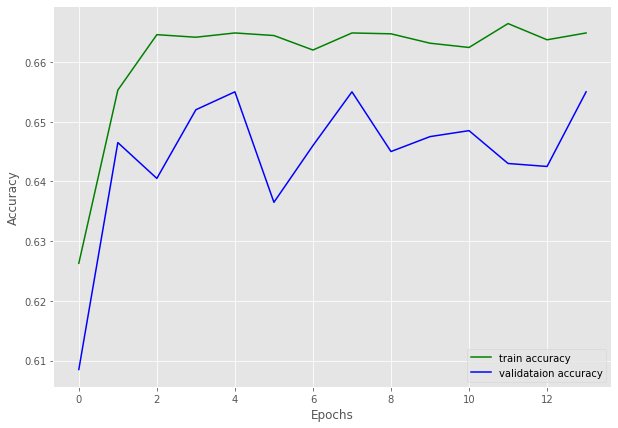

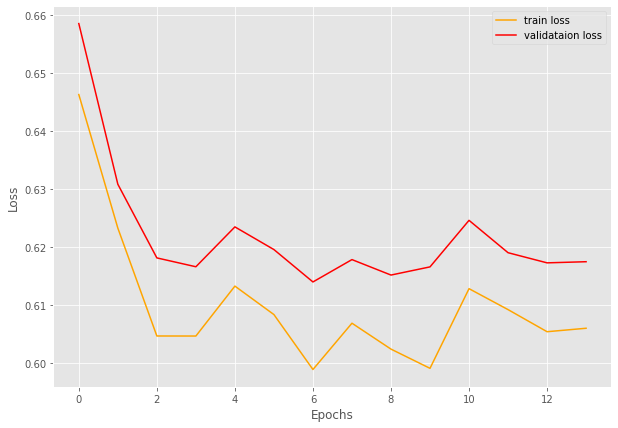

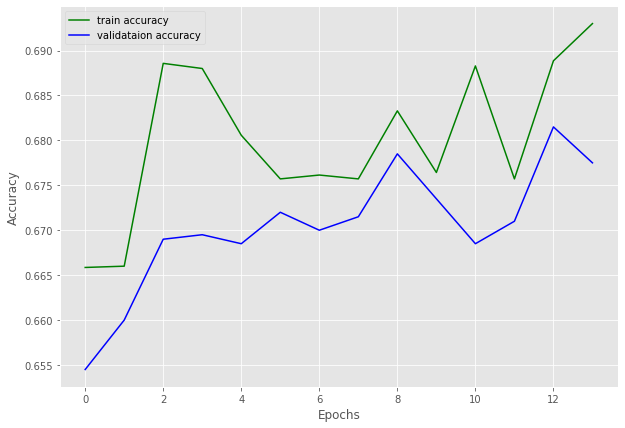

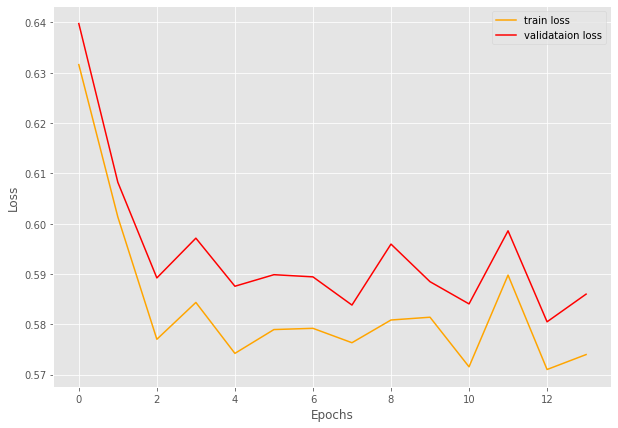

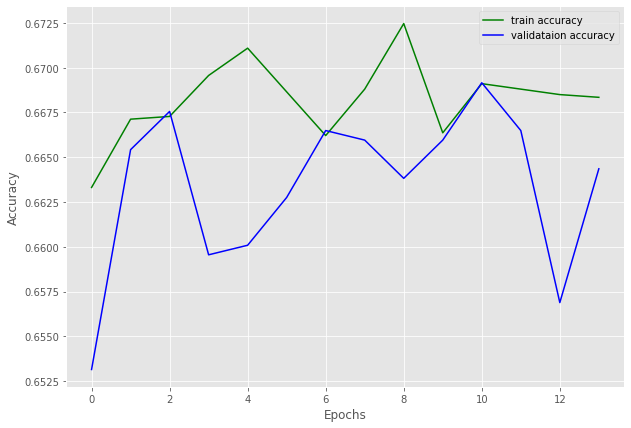

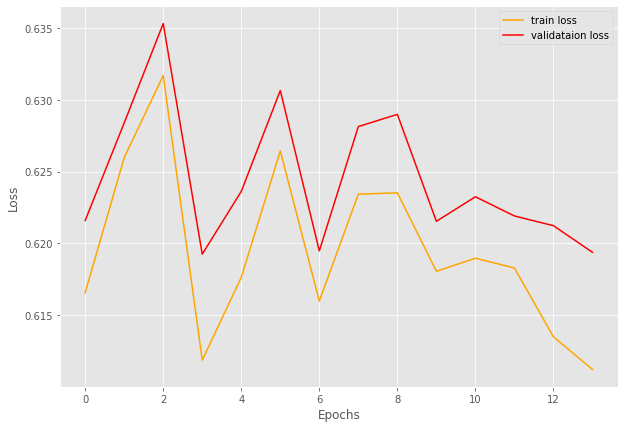

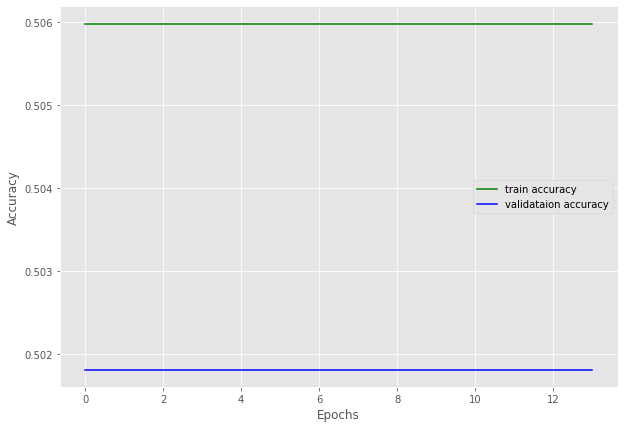

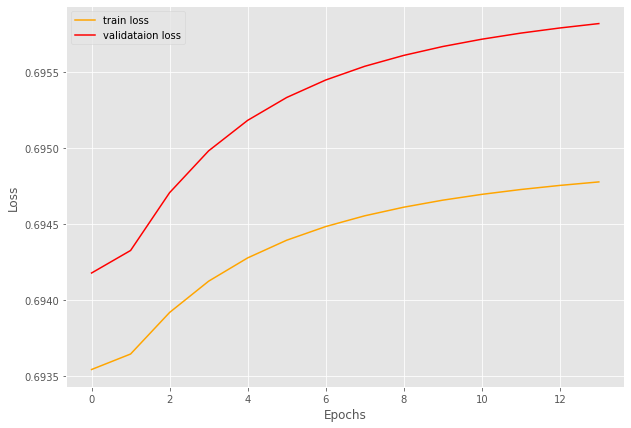

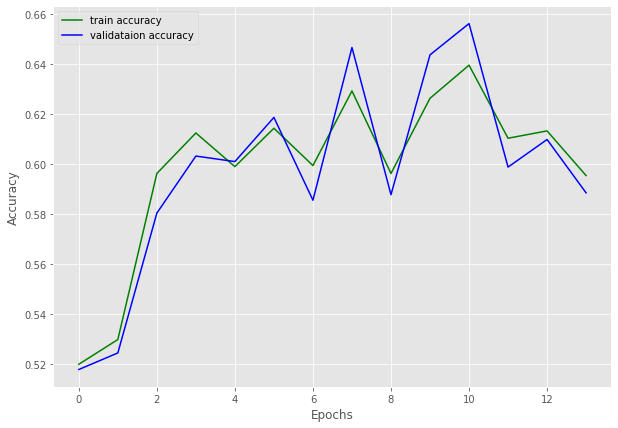

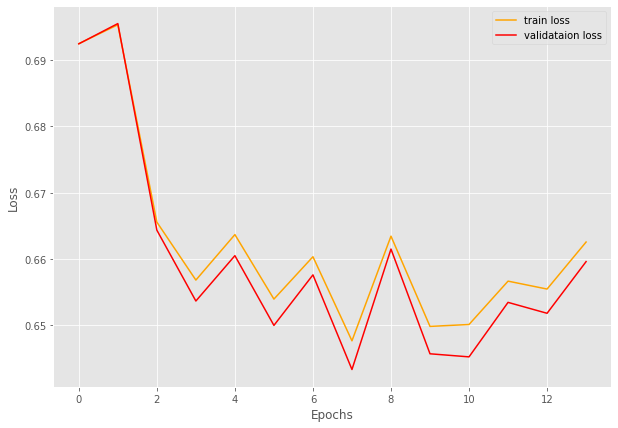

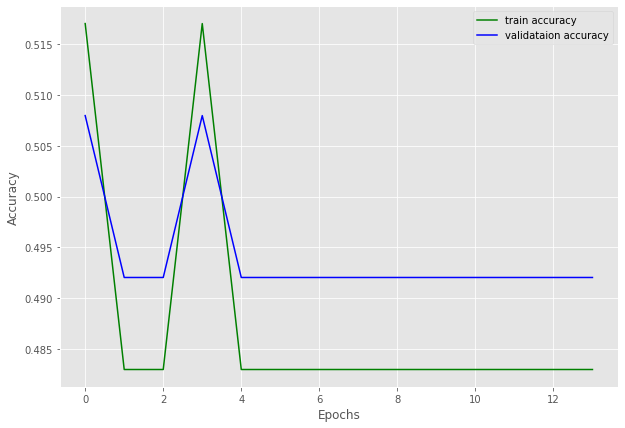

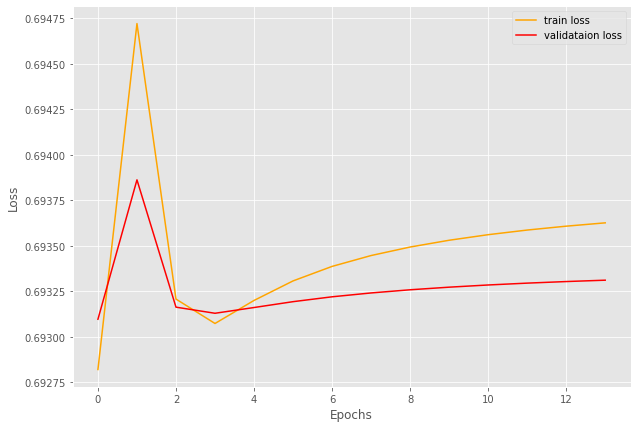

In [13]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)
  #print(f"Feature-Anzahl: {num_feature}")

  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)  

  # tuning
  param = {"lr": 0.05, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_2
save Hyperparameter
Epoch: 001, Train Acc: 0.6507, Validation Acc: 0.6620, Loss Training: 0.6536, Loss Validation: 0.6504
Epoch: 002, Train Acc: 0.6541, Validation Acc: 0.6620, Loss Training: 0.6314, Loss Validation: 0.6246
Epoch: 003, Train Acc: 0.6516, Validation Acc: 0.6595, Loss Training: 0.6260, Loss Validation: 0.6230
Epoch: 004, Train Acc: 0.6540, Validation Acc: 0.6625, Loss Training: 0.6171, Loss Validation: 0.6137
Epoch: 005, Train Acc: 0.6537, Validation Acc: 0.6595, Loss Training: 0.6103, Loss Validation: 0.6083
Epoch: 006, Train Acc: 0.6503, Validation Acc: 0.6570, Loss Training: 0.6050, Loss Validation: 0.6045
Epoch: 007, Train Acc: 0.6514, Validation Acc: 0.6570, Loss Training: 0.6019, Loss Validation: 0.6030
Epoch: 008, Train Acc: 0.6547, Validation Acc: 0.6585, Loss Training: 0.6019, Loss Validation: 0.6052
Epoch: 009, Train A

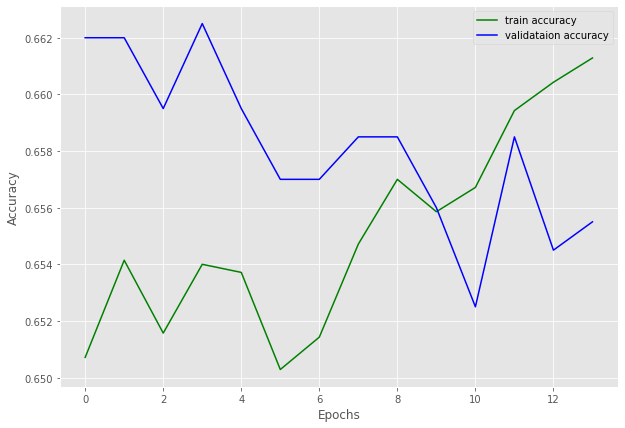

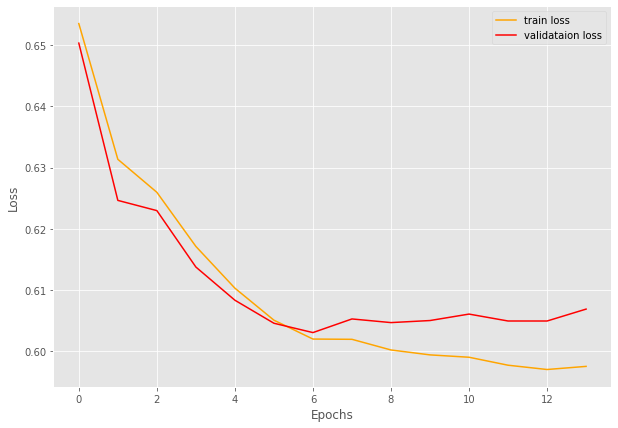

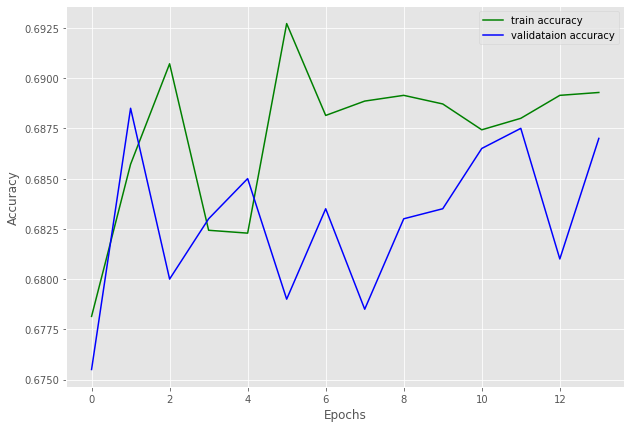

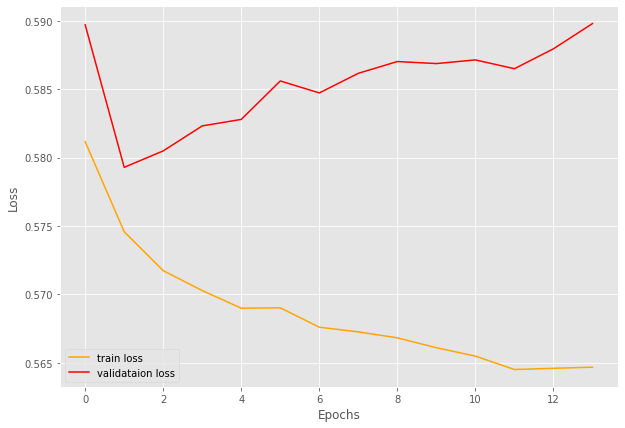

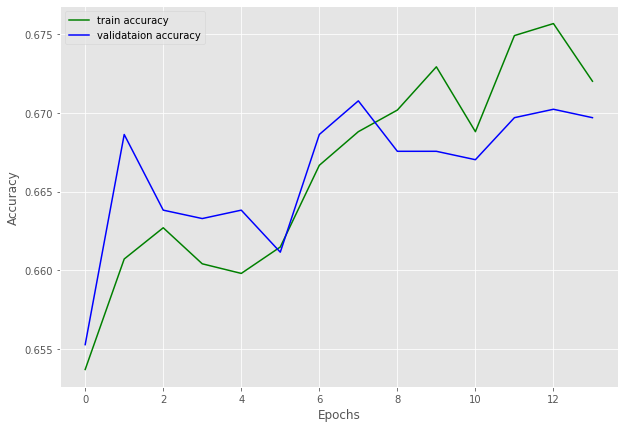

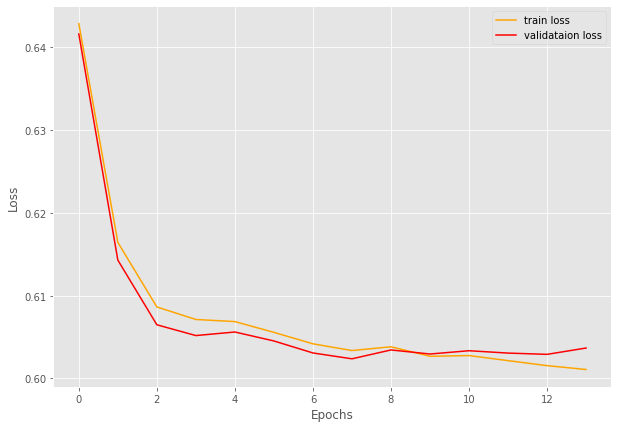

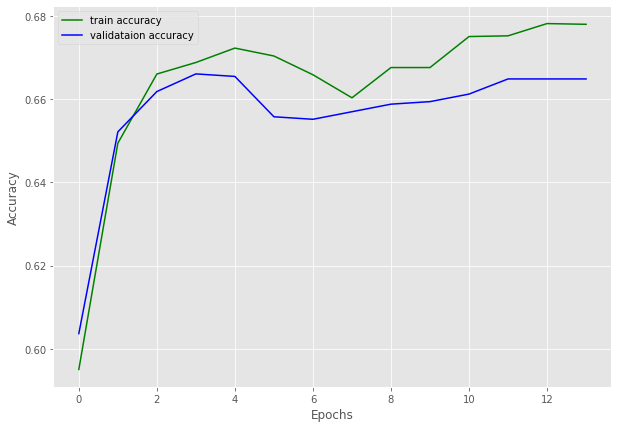

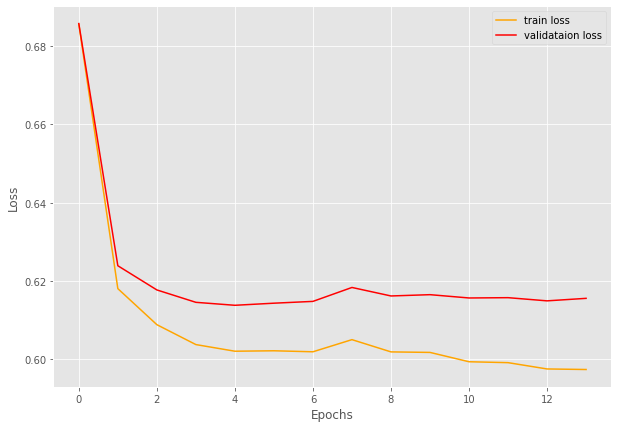

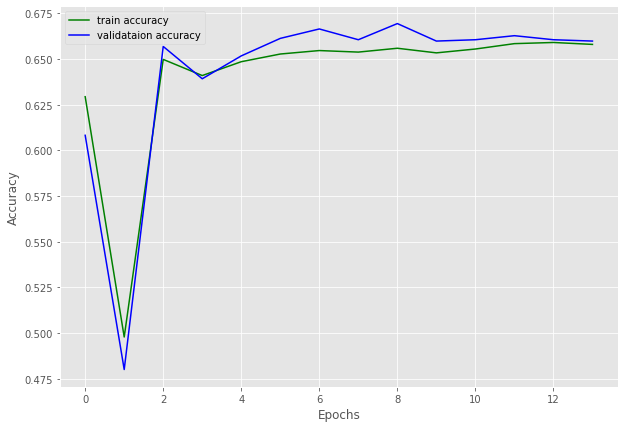

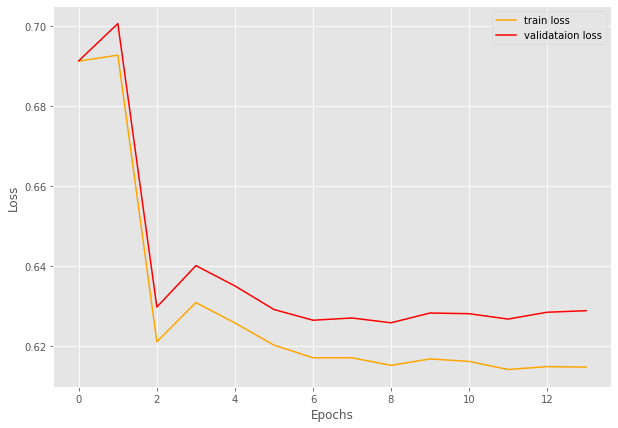

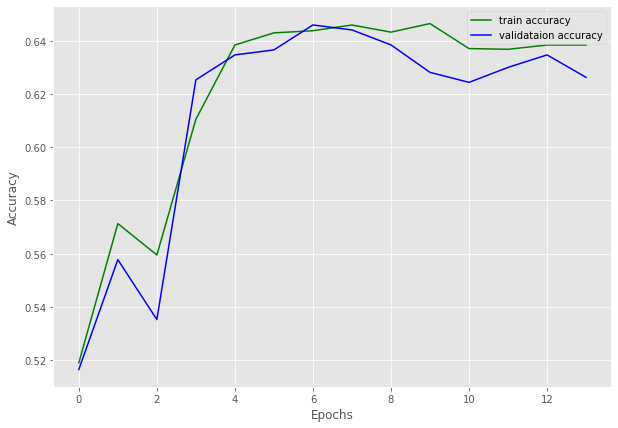

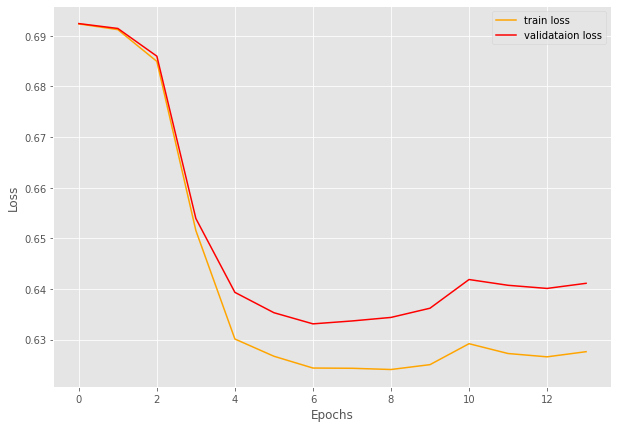

In [14]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)  

  # tuning
  param = {"lr": 0.001, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_3
save Hyperparameter
Epoch: 001, Train Acc: 0.6570, Validation Acc: 0.6575, Loss Training: 0.6249, Loss Validation: 0.6267
Epoch: 002, Train Acc: 0.6633, Validation Acc: 0.6560, Loss Training: 0.6050, Loss Validation: 0.6048
Epoch: 003, Train Acc: 0.6591, Validation Acc: 0.6560, Loss Training: 0.5999, Loss Validation: 0.5988
Epoch: 004, Train Acc: 0.6606, Validation Acc: 0.6540, Loss Training: 0.5982, Loss Validation: 0.5966
Epoch: 005, Train Acc: 0.6607, Validation Acc: 0.6510, Loss Training: 0.5977, Loss Validation: 0.5974
Epoch: 006, Train Acc: 0.6613, Validation Acc: 0.6525, Loss Training: 0.5971, Loss Validation: 0.5973
Epoch: 007, Train Acc: 0.6610, Validation Acc: 0.6470, Loss Training: 0.5966, Loss Validation: 0.5970
Epoch: 008, Train Acc: 0.6627, Validation Acc: 0.6495, Loss Training: 0.5972, Loss Validation: 0.5982
Epoch: 009, Train A

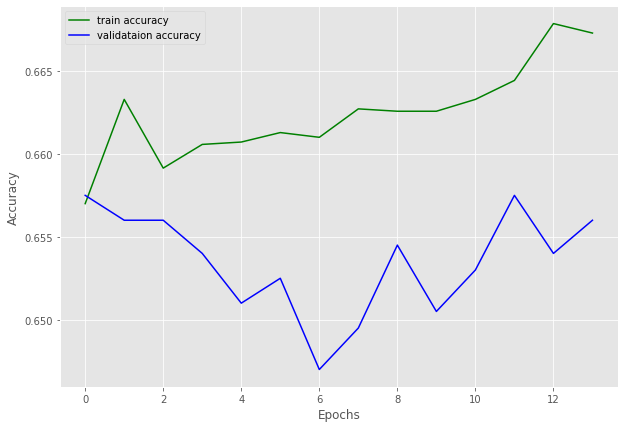

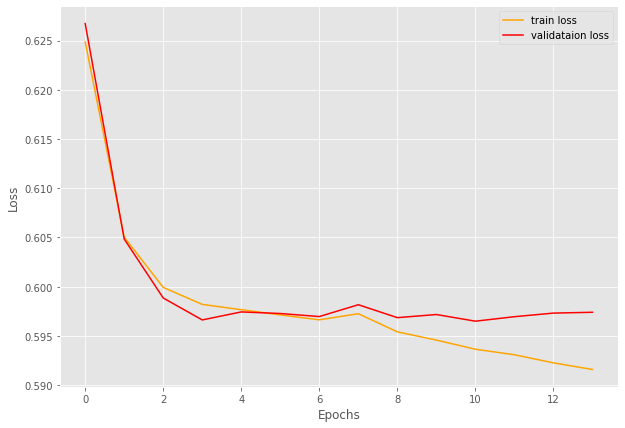

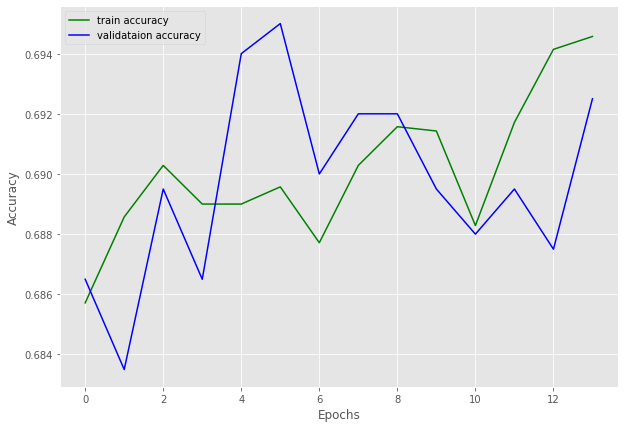

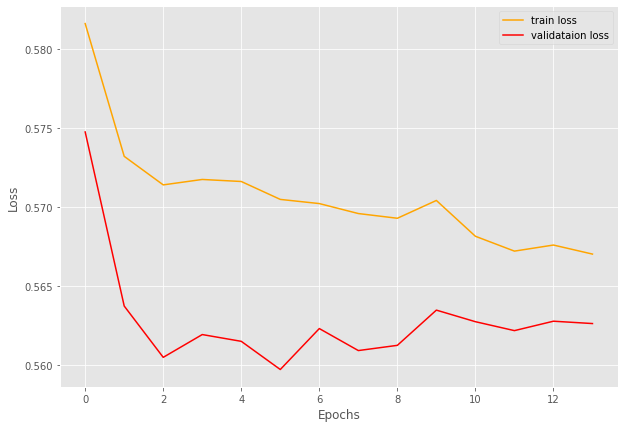

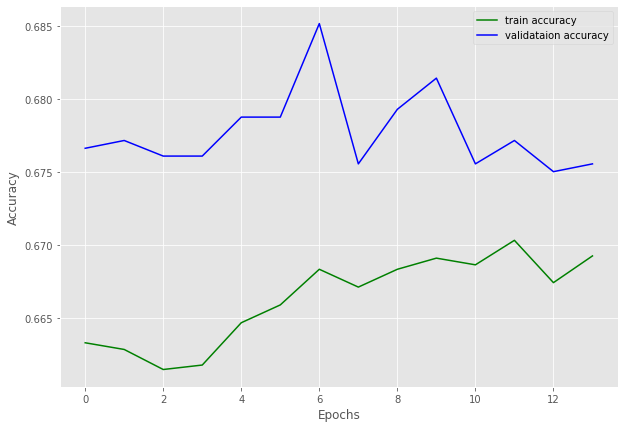

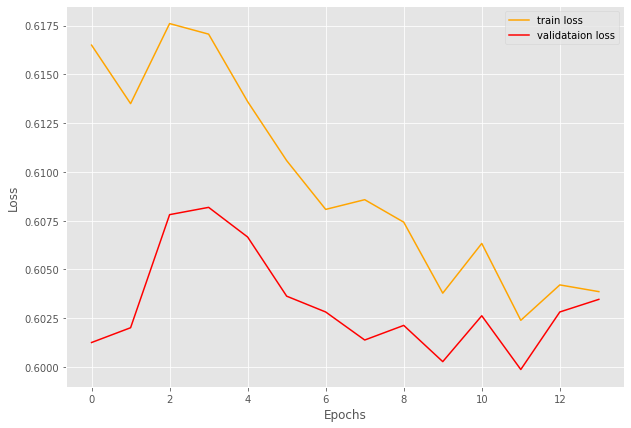

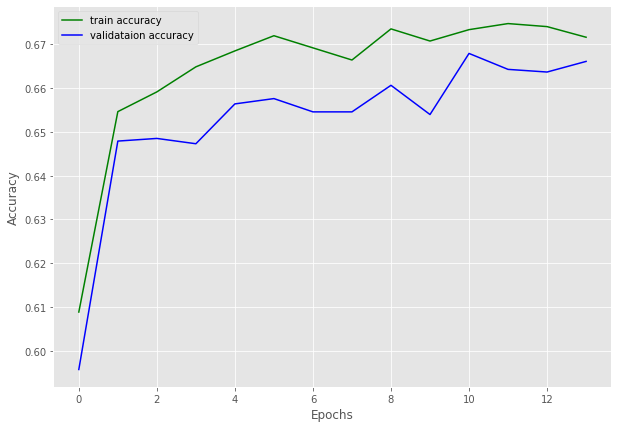

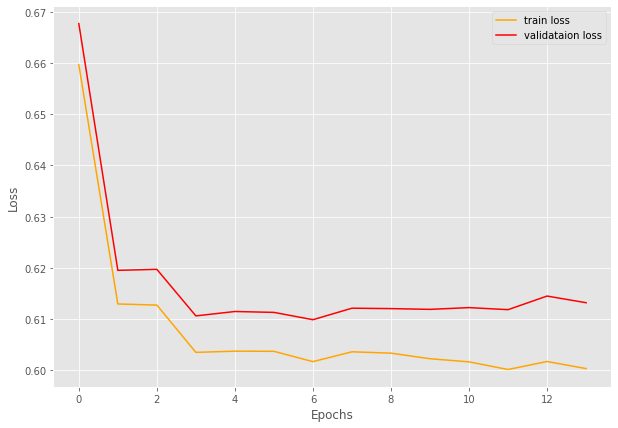

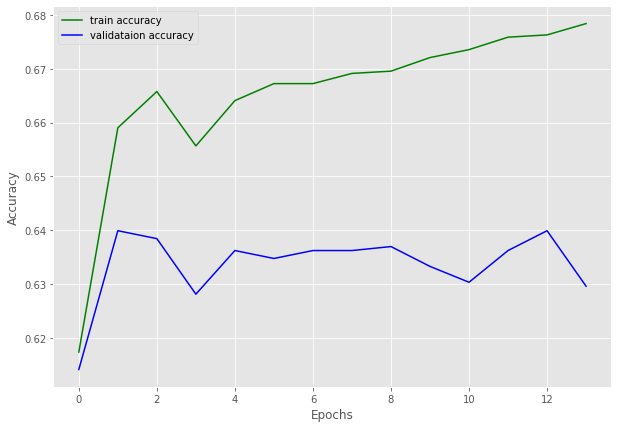

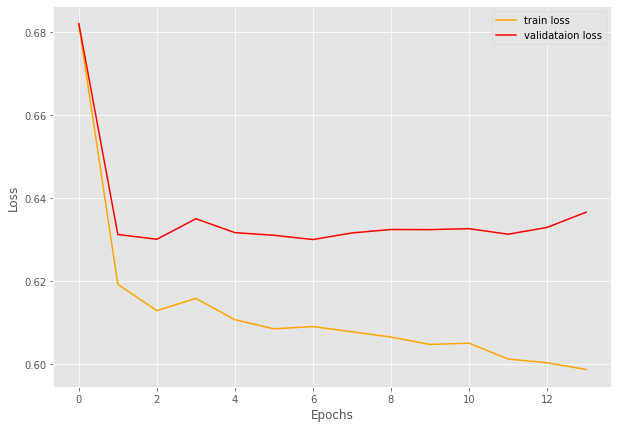

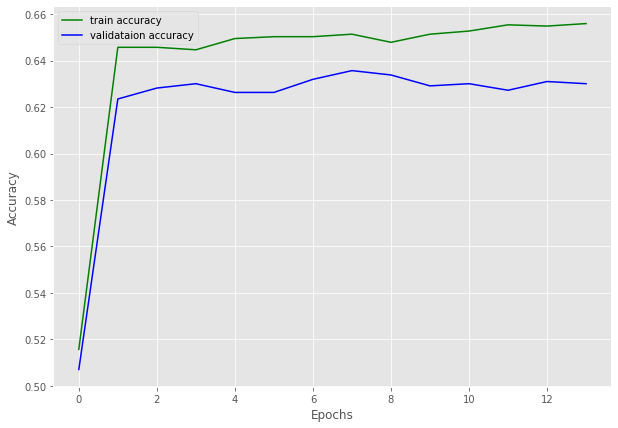

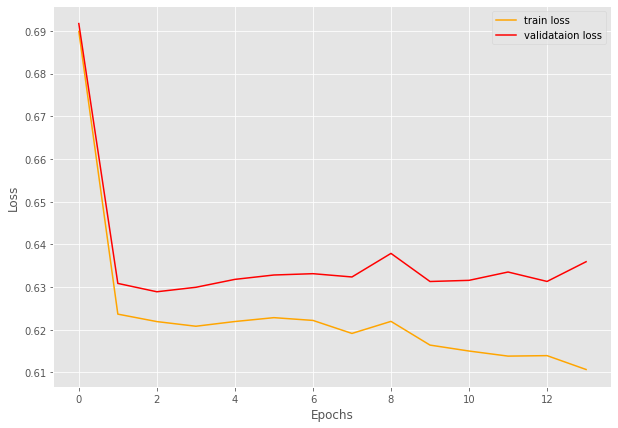

In [15]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)  
  param = {"lr": 0.005, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_4
save Hyperparameter
Epoch: 001, Train Acc: 0.5110, Validation Acc: 0.4950, Loss Training: 0.6925, Loss Validation: 0.6929
Epoch: 002, Train Acc: 0.5110, Validation Acc: 0.4950, Loss Training: 0.6914, Loss Validation: 0.6919
Epoch: 003, Train Acc: 0.6216, Validation Acc: 0.6065, Loss Training: 0.6881, Loss Validation: 0.6883
Epoch: 004, Train Acc: 0.6553, Validation Acc: 0.6525, Loss Training: 0.6782, Loss Validation: 0.6782
Epoch: 005, Train Acc: 0.6531, Validation Acc: 0.6580, Loss Training: 0.6602, Loss Validation: 0.6596
Epoch: 006, Train Acc: 0.6527, Validation Acc: 0.6540, Loss Training: 0.6412, Loss Validation: 0.6404
Epoch: 007, Train Acc: 0.6539, Validation Acc: 0.6565, Loss Training: 0.6329, Loss Validation: 0.6326
Epoch: 008, Train Acc: 0.6546, Validation Acc: 0.6560, Loss Training: 0.6309, Loss Validation: 0.6305
Epoch: 009, Train A

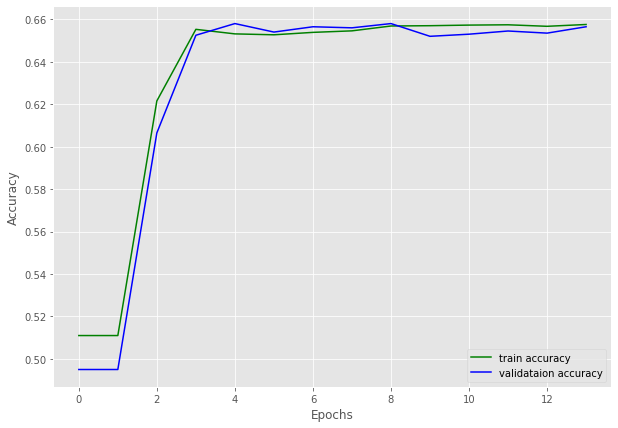

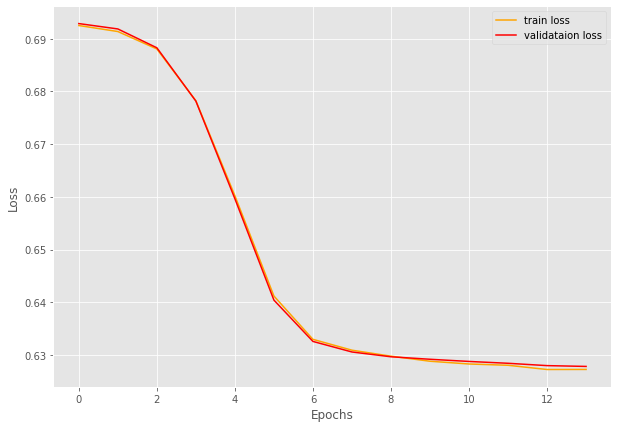

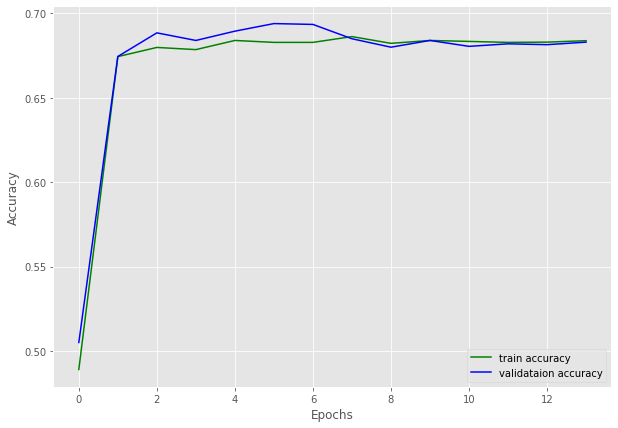

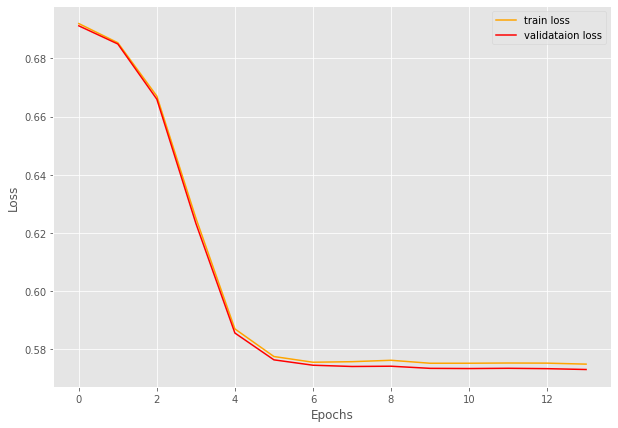

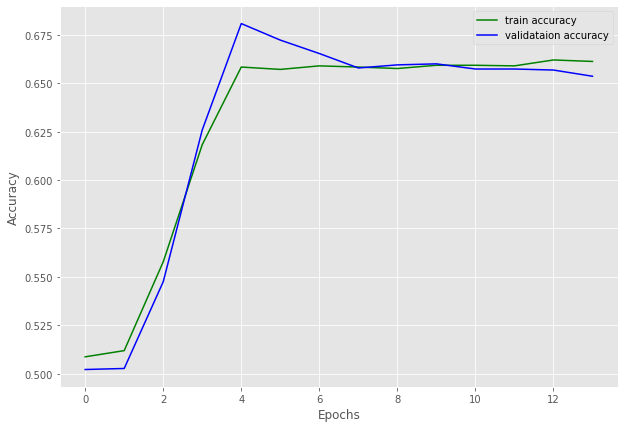

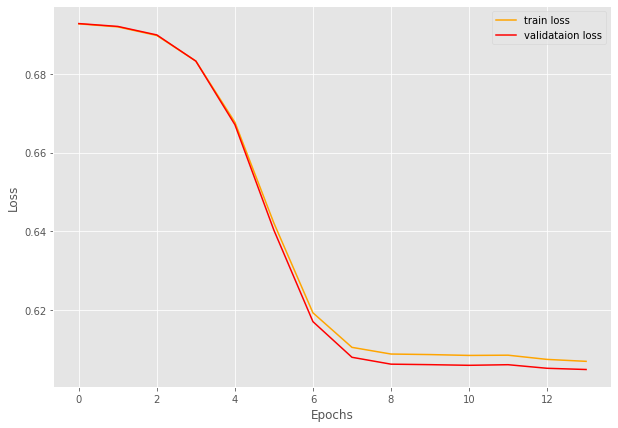

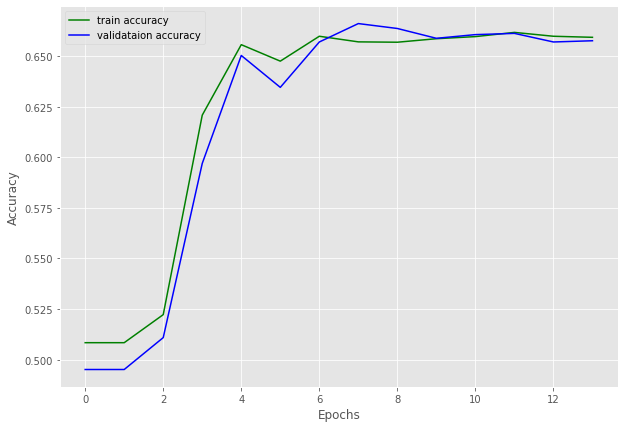

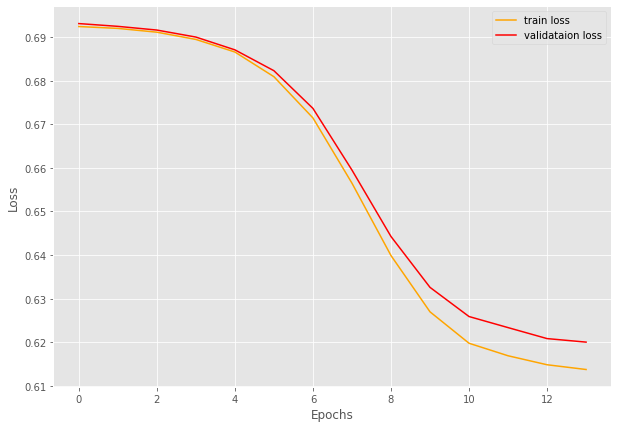

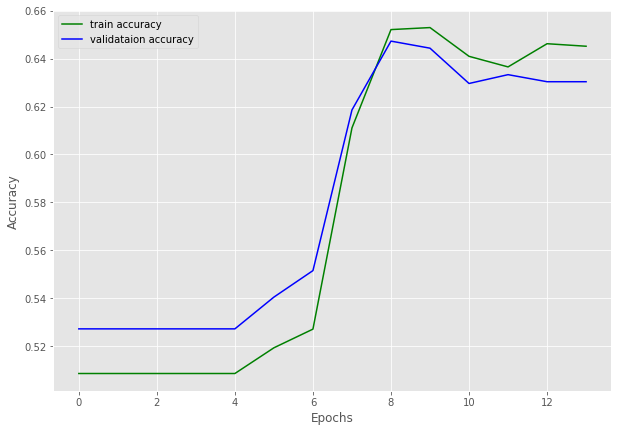

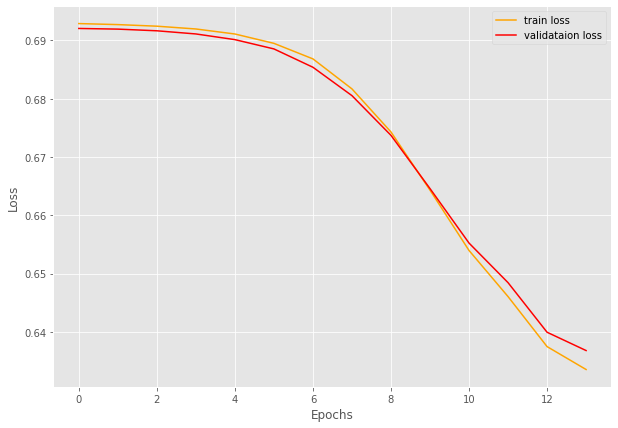

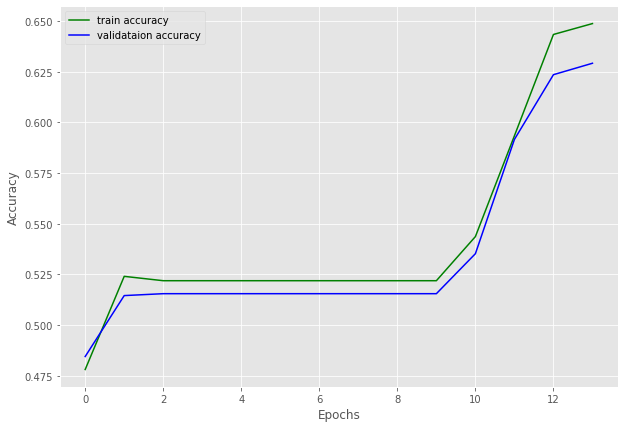

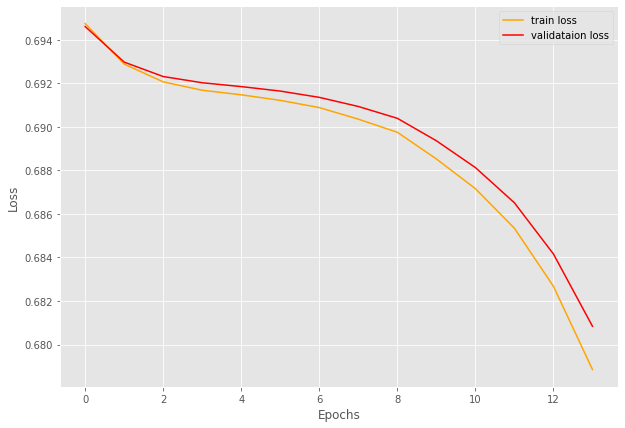

In [16]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer) 
  param = {"lr": 0.0001, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_5
save Hyperparameter
Epoch: 001, Train Acc: 0.6237, Validation Acc: 0.6390, Loss Training: 0.6816, Loss Validation: 0.6808
Epoch: 002, Train Acc: 0.6560, Validation Acc: 0.6625, Loss Training: 0.6320, Loss Validation: 0.6246
Epoch: 003, Train Acc: 0.6530, Validation Acc: 0.6630, Loss Training: 0.6297, Loss Validation: 0.6245
Epoch: 004, Train Acc: 0.6579, Validation Acc: 0.6595, Loss Training: 0.6257, Loss Validation: 0.6218
Epoch: 005, Train Acc: 0.6569, Validation Acc: 0.6575, Loss Training: 0.6218, Loss Validation: 0.6194
Epoch: 006, Train Acc: 0.6563, Validation Acc: 0.6610, Loss Training: 0.6187, Loss Validation: 0.6176
Epoch: 007, Train Acc: 0.6560, Validation Acc: 0.6615, Loss Training: 0.6152, Loss Validation: 0.6158
Epoch: 008, Train Acc: 0.6579, Validation Acc: 0.6560, Loss Training: 0.6107, Loss Validation: 0.6134
Epoch: 009, Train A

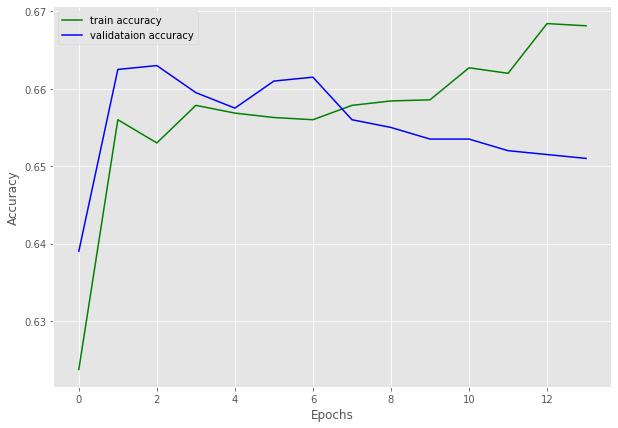

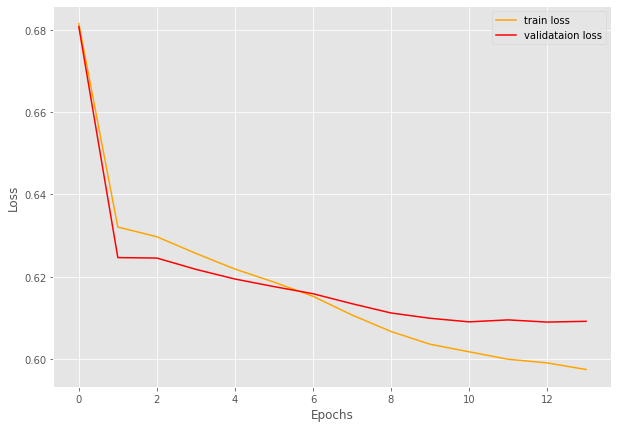

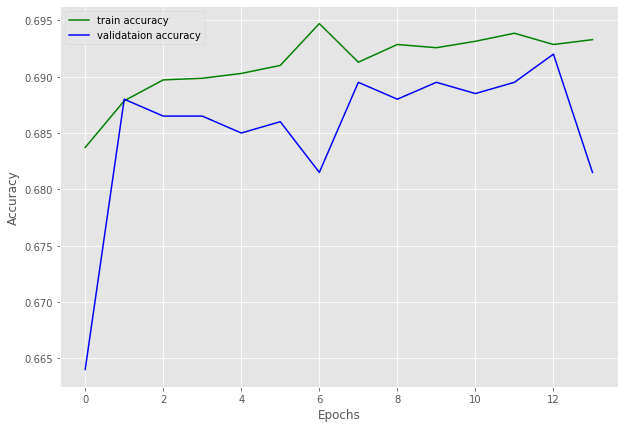

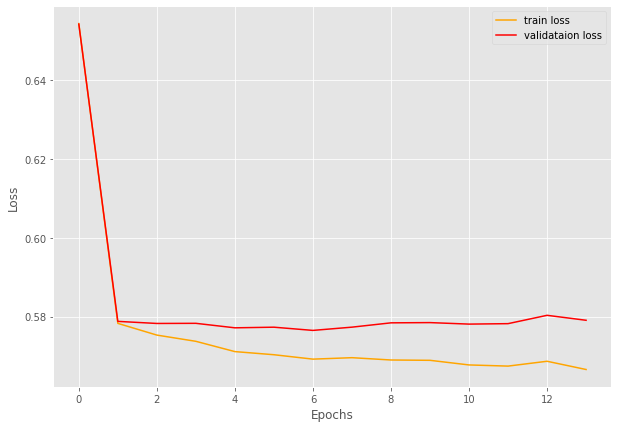

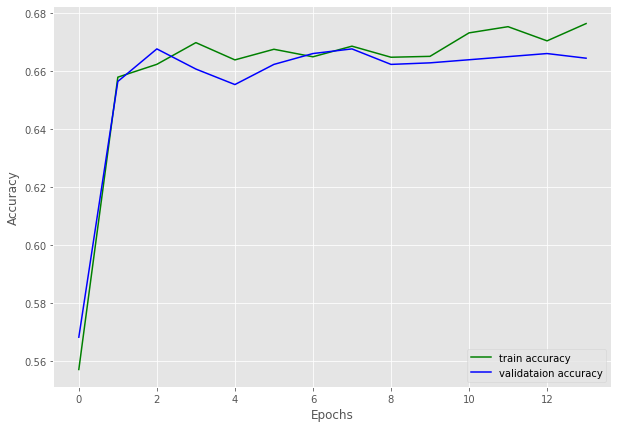

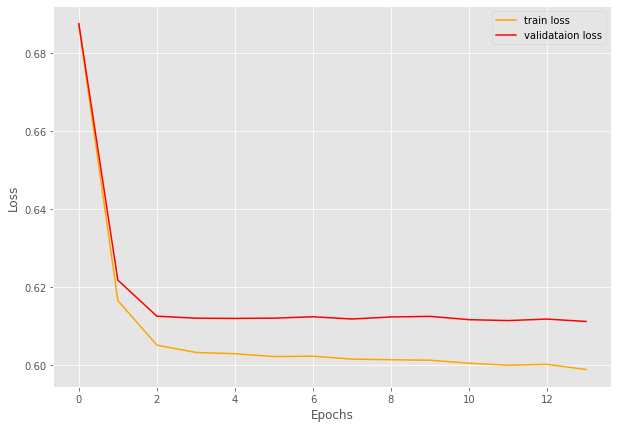

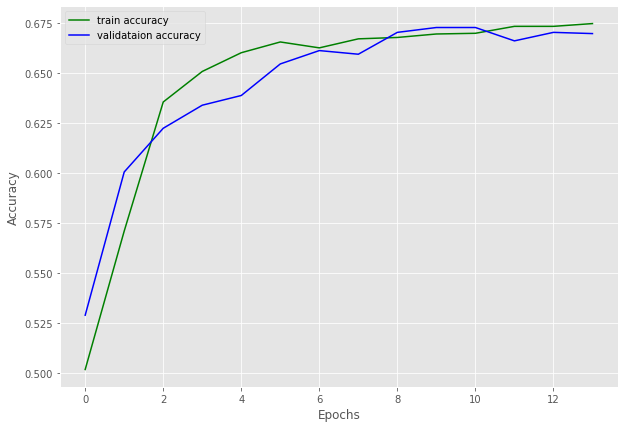

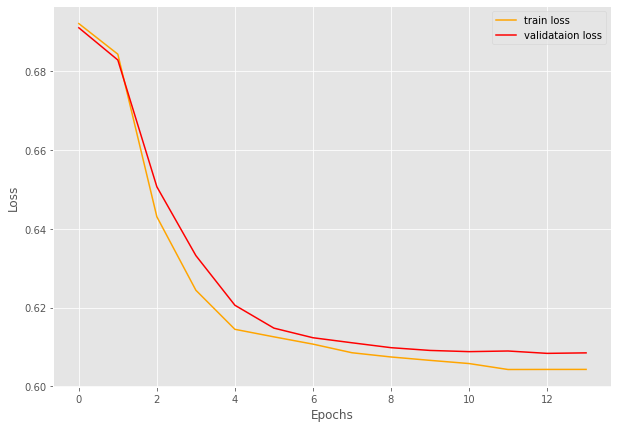

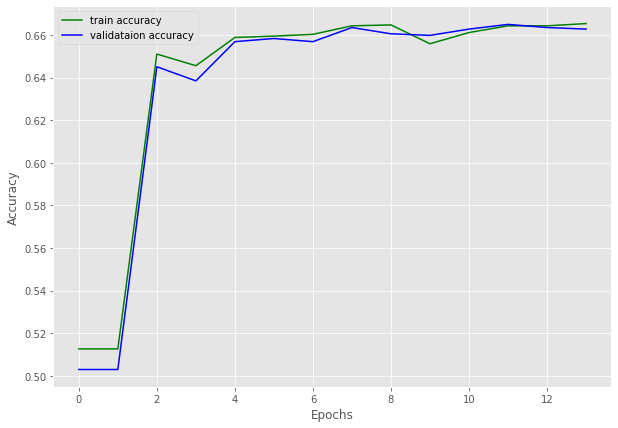

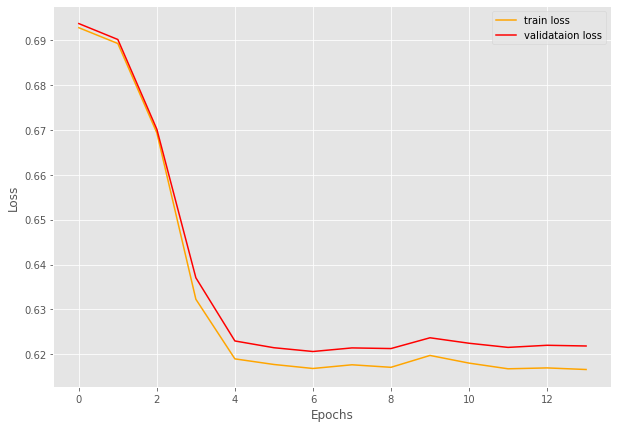

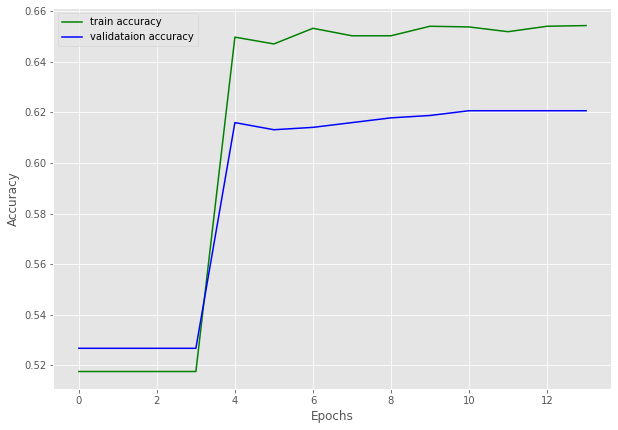

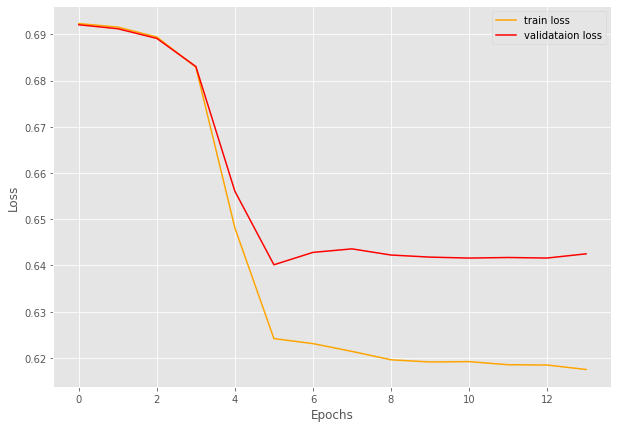

In [17]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer) 
  param = {"lr": 0.0005, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_6
save Hyperparameter
Epoch: 001, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6944, Loss Validation: 0.6975
Epoch: 002, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6940, Loss Validation: 0.6969
Epoch: 003, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6938, Loss Validation: 0.6963
Epoch: 004, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6935, Loss Validation: 0.6958
Epoch: 005, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6934, Loss Validation: 0.6954
Epoch: 006, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6932, Loss Validation: 0.6951
Epoch: 007, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6930, Loss Validation: 0.6948
Epoch: 008, Train Acc: 0.5029, Validation Acc: 0.4725, Loss Training: 0.6929, Loss Validation: 0.6945
Epoch: 009, Train A

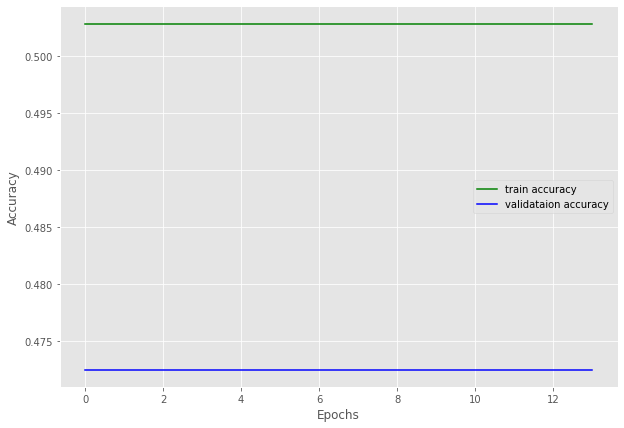

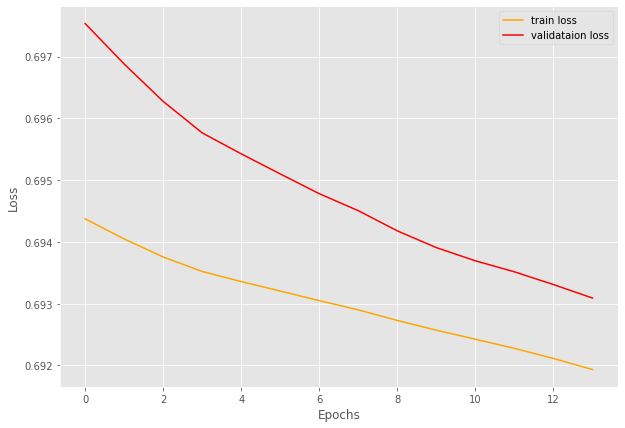

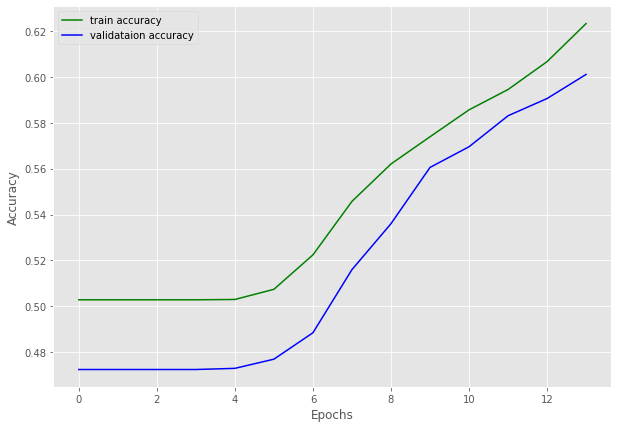

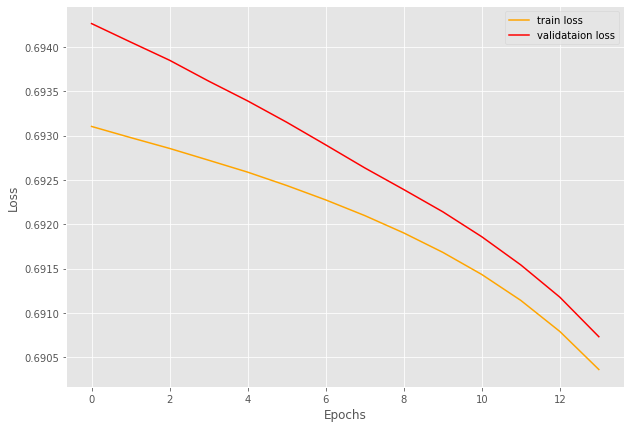

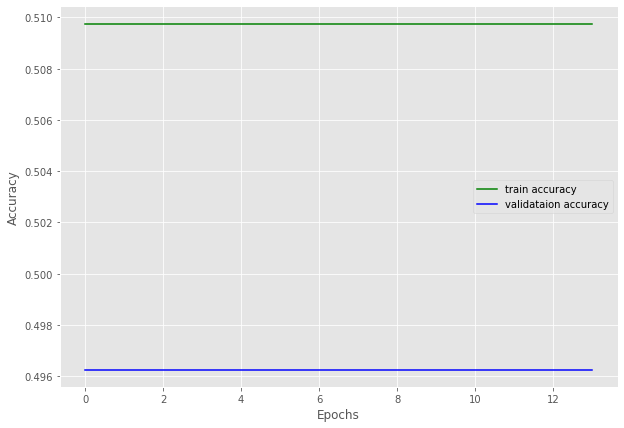

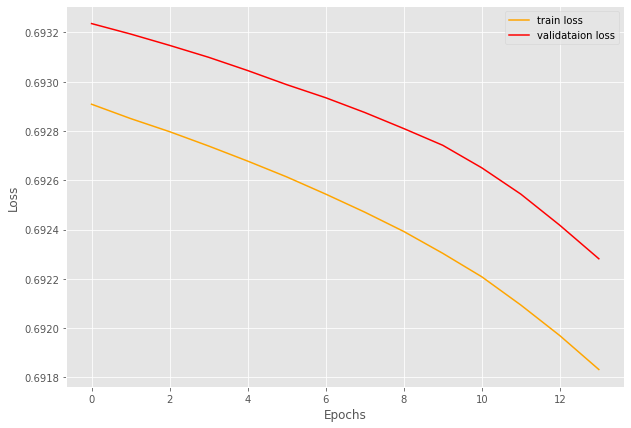

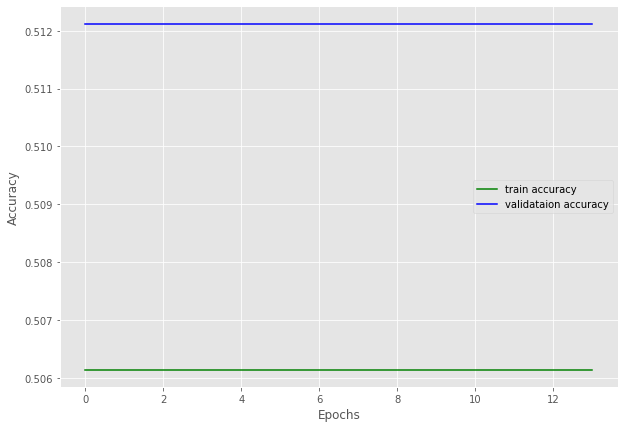

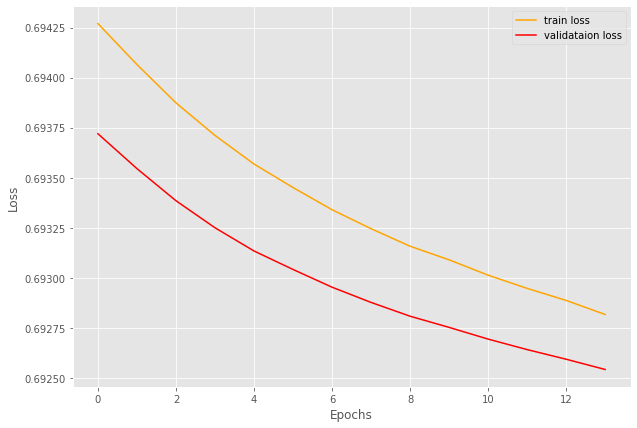

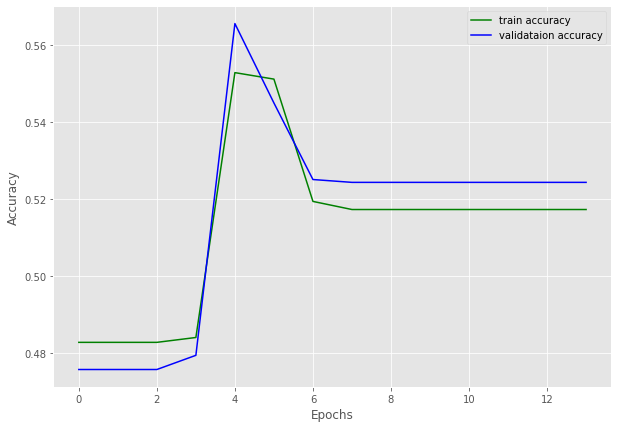

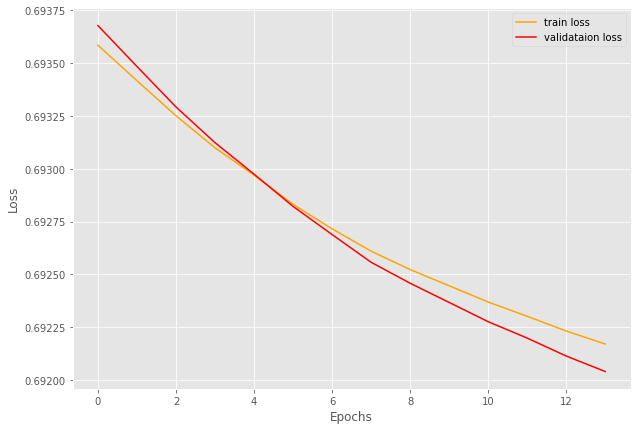

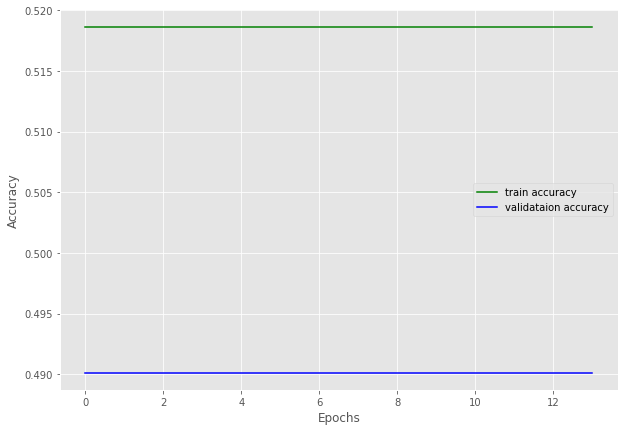

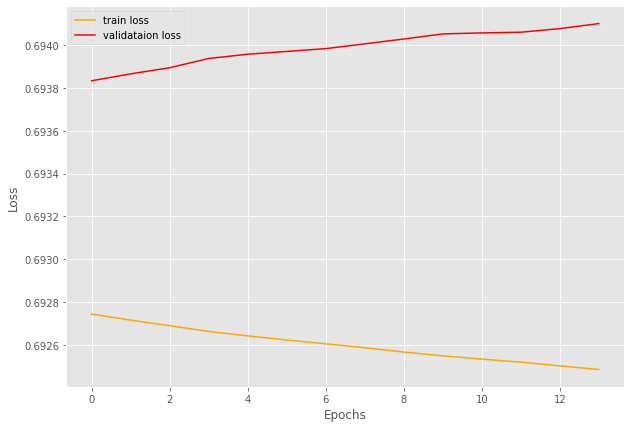

In [18]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer) 
  param = {"lr": 0.00001, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/models/tuning/review_all_events_f5_ohe_2_prefix_4/run_7
save Hyperparameter
Epoch: 001, Train Acc: 0.5039, Validation Acc: 0.5165, Loss Training: 0.6930, Loss Validation: 0.6922
Epoch: 002, Train Acc: 0.5039, Validation Acc: 0.5165, Loss Training: 0.6922, Loss Validation: 0.6917
Epoch: 003, Train Acc: 0.5041, Validation Acc: 0.5145, Loss Training: 0.6914, Loss Validation: 0.6911
Epoch: 004, Train Acc: 0.5656, Validation Acc: 0.5635, Loss Training: 0.6902, Loss Validation: 0.6900
Epoch: 005, Train Acc: 0.6133, Validation Acc: 0.6060, Loss Training: 0.6883, Loss Validation: 0.6881
Epoch: 006, Train Acc: 0.6196, Validation Acc: 0.6185, Loss Training: 0.6852, Loss Validation: 0.6848
Epoch: 007, Train Acc: 0.6231, Validation Acc: 0.6280, Loss Training: 0.6806, Loss Validation: 0.6800
Epoch: 008, Train Acc: 0.6424, Validation Acc: 0.6460, Loss Training: 0.6741, Loss Validation: 0.6735
Epoch: 009, Train A

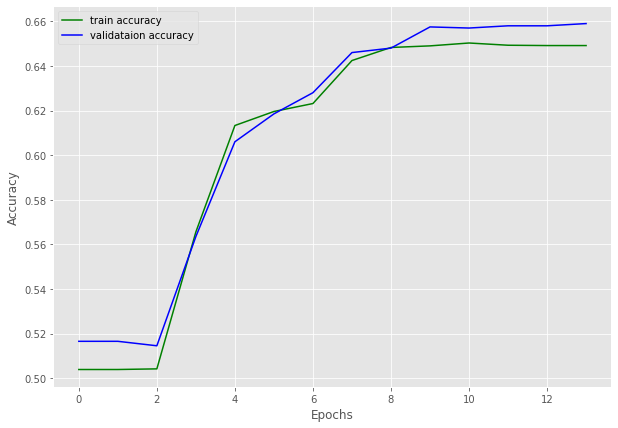

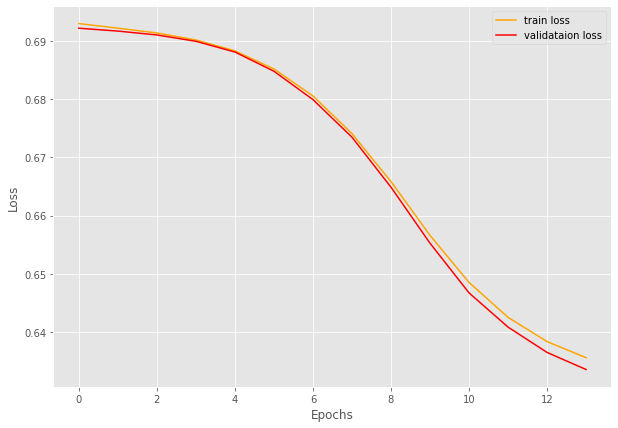

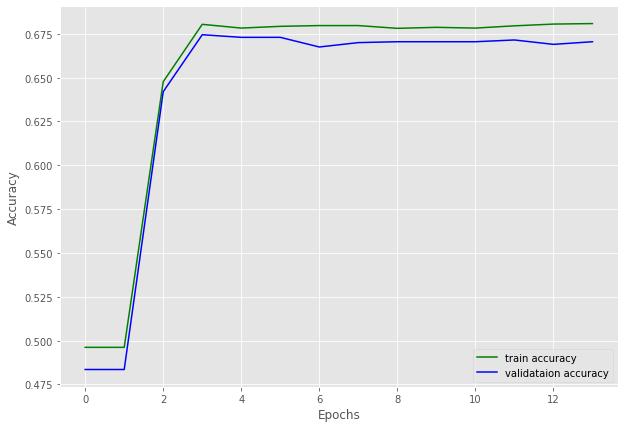

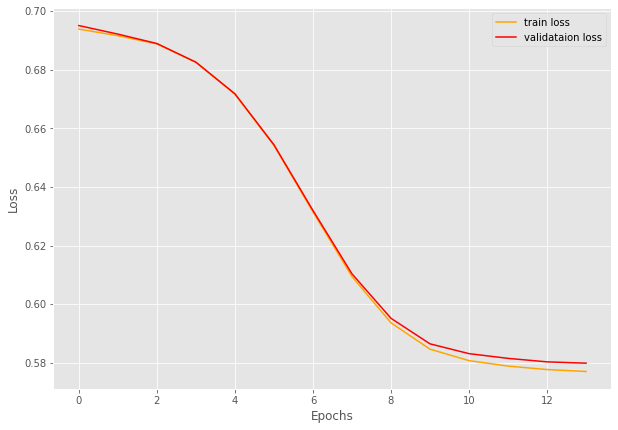

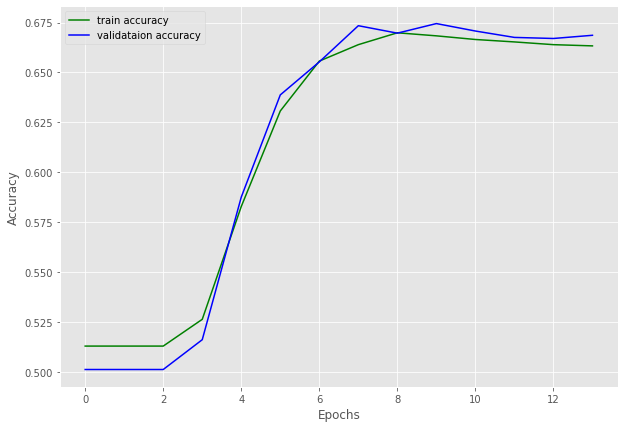

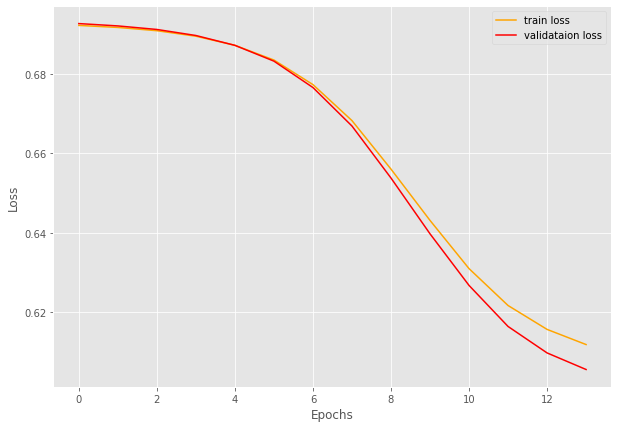

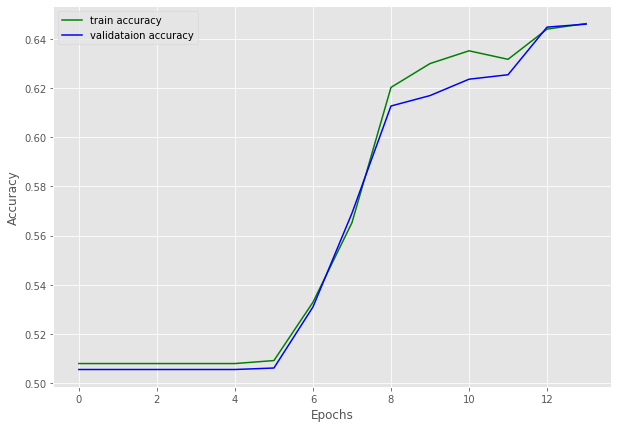

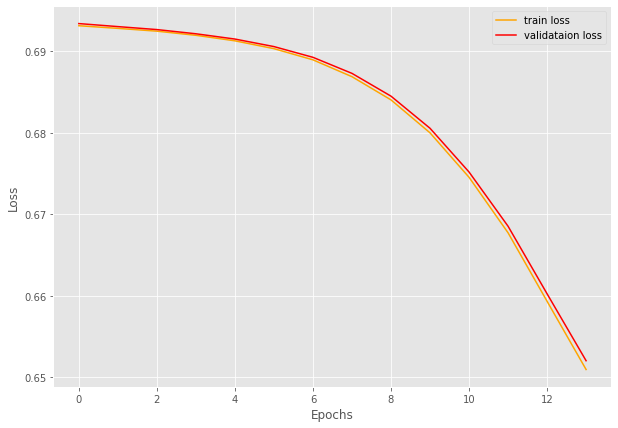

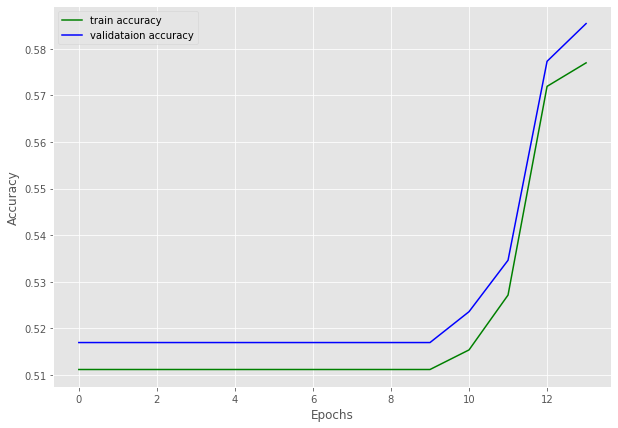

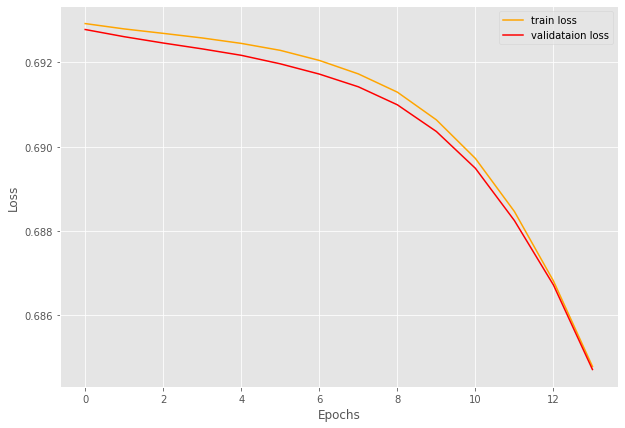

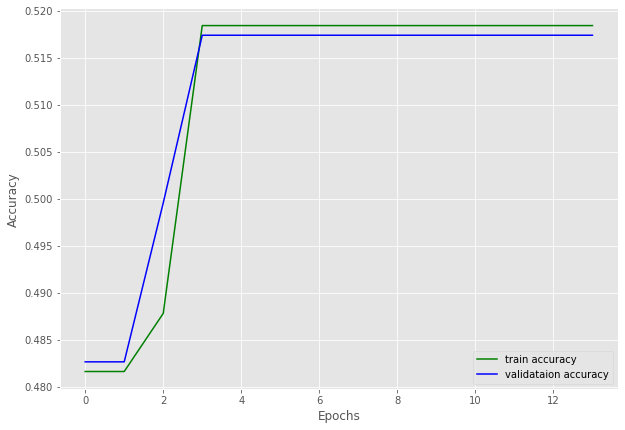

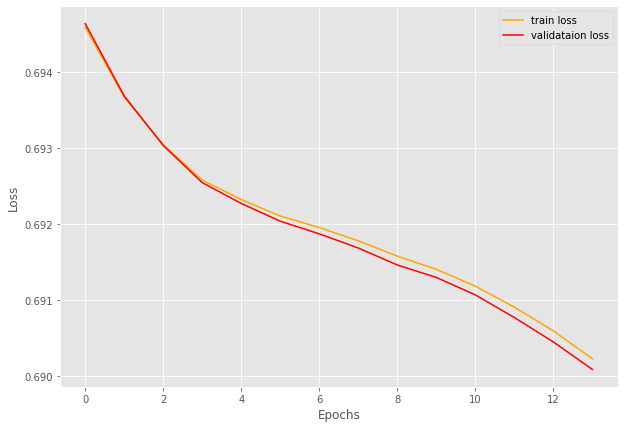

In [19]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Über alle Präfix-Längen iterieren
for key in dataset_list_review:
  print(f"-------------Präfix: {key}--------------")
  # Variablen besetzen
  dataset = dataset_list_review[key]
  train_loader, val_loader, test_loader  = create_splitted_dataloader(dataset, batch_size)
  num_feature = dataset[0].x.size(1)


  #model
  gcn_model = instantiate_model(hidden_channel, num_feature, num_layer) 
  param = {"lr": 0.00005, "num_epochs": 15}
  run_tuning(param, path, dataset_name + "_" + str(key), gcn_model, device, train_loader, val_loader, test_loader)

## Training ausführen

In [12]:
learning_rate = { # #0.005
    0: 0.0001,     
    4: 0.0001,
    7: 0.0001,
    10: 0.00005,
    13: 0.00005,
    16: 0.00005,
    19: 0.0001
}


In [14]:
num_epochs = 200
batch_size = 100
#learning_rate = 0.0001  # 0.001
num_layer = 3
hidden_channel = 100

#### Länge 4

In [27]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 4
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 4--------------
Epoch: 001, Train Acc: 0.5110, Validation Acc: 0.4935, Loss train: 0.6920136647565024, Loss val: 0.6928553730249405
Epoch: 002, Train Acc: 0.5110, Validation Acc: 0.4935, Loss train: 0.6904901019164494, Loss val: 0.6915142744779587
Epoch: 003, Train Acc: 0.6111, Validation Acc: 0.6090, Loss train: 0.6865556197507041, Loss val: 0.6875749081373215
Epoch: 004, Train Acc: 0.6509, Validation Acc: 0.6415, Loss train: 0.6764174367700304, Loss val: 0.6775831043720245
Epoch: 005, Train Acc: 0.6541, Validation Acc: 0.6415, Loss train: 0.6591774812766484, Loss val: 0.6609496146440506
Epoch: 006, Train Acc: 0.6556, Validation Acc: 0.6420, Loss train: 0.6417365542479924, Loss val: 0.6448330342769623
Epoch: 007, Train Acc: 0.6491, Validation Acc: 0.6445, Loss train: 0.6359171611922128, Loss val: 0.6395286411046982
Epoch: 008, Train Acc: 0.6550, Validation Acc: 0.6460, Loss train: 0.6325913386685508, Loss val: 0.636964026093483
Epoch: 009, Train Acc: 0.6550, Valid

####Länge 7

In [28]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 7
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 7--------------
Epoch: 001, Train Acc: 0.5119, Validation Acc: 0.4945, Loss train: 0.6912007246698652, Loss val: 0.6917245566844941
Epoch: 002, Train Acc: 0.6096, Validation Acc: 0.6005, Loss train: 0.6855868399143219, Loss val: 0.6865992367267608
Epoch: 003, Train Acc: 0.6846, Validation Acc: 0.6805, Loss train: 0.6657303622790746, Loss val: 0.6672843307256698
Epoch: 004, Train Acc: 0.6796, Validation Acc: 0.6685, Loss train: 0.6223447493144444, Loss val: 0.625960859656334
Epoch: 005, Train Acc: 0.6827, Validation Acc: 0.6735, Loss train: 0.5849232477801186, Loss val: 0.5919849306344986
Epoch: 006, Train Acc: 0.6809, Validation Acc: 0.6725, Loss train: 0.5784406227724893, Loss val: 0.5867859333753586
Epoch: 007, Train Acc: 0.6800, Validation Acc: 0.6705, Loss train: 0.5770274579524994, Loss val: 0.5860394209623336
Epoch: 008, Train Acc: 0.6786, Validation Acc: 0.6710, Loss train: 0.5765030422380992, Loss val: 0.585875391960144
Epoch: 009, Train Acc: 0.6790, Valida

####Länge 10

In [29]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 10
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 10--------------
Epoch: 001, Train Acc: 0.4931, Validation Acc: 0.5000, Loss train: 0.6929169513962485, Loss val: 0.6928583509043643
Epoch: 002, Train Acc: 0.5137, Validation Acc: 0.5059, Loss train: 0.6924781609665264, Loss val: 0.6925729732764395
Epoch: 003, Train Acc: 0.5088, Validation Acc: 0.5011, Loss train: 0.6920309960842133, Loss val: 0.6922375371581629
Epoch: 004, Train Acc: 0.5088, Validation Acc: 0.5011, Loss train: 0.6913672477910013, Loss val: 0.691681516797919
Epoch: 005, Train Acc: 0.5136, Validation Acc: 0.5043, Loss train: 0.6903424615209753, Loss val: 0.6907800216423837
Epoch: 006, Train Acc: 0.5514, Validation Acc: 0.5411, Loss train: 0.6885102454460028, Loss val: 0.6891320410527682
Epoch: 007, Train Acc: 0.6284, Validation Acc: 0.6003, Loss train: 0.6850470259334102, Loss val: 0.6859456237993742
Epoch: 008, Train Acc: 0.6613, Validation Acc: 0.6489, Loss train: 0.6792505302212455, Loss val: 0.6804648857367667
Epoch: 009, Train Acc: 0.6612, Vali

####Länge 13

In [30]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 13
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 13--------------
Epoch: 001, Train Acc: 0.5060, Validation Acc: 0.5018, Loss train: 0.6931452843649634, Loss val: 0.6936298889272353
Epoch: 002, Train Acc: 0.5060, Validation Acc: 0.5018, Loss train: 0.6928809007693981, Loss val: 0.6932495131212122
Epoch: 003, Train Acc: 0.5060, Validation Acc: 0.5018, Loss train: 0.6926844171408949, Loss val: 0.6930001693613389
Epoch: 004, Train Acc: 0.5060, Validation Acc: 0.5018, Loss train: 0.6924538982325587, Loss val: 0.6926891172633451
Epoch: 005, Train Acc: 0.5060, Validation Acc: 0.5018, Loss train: 0.6921691493741398, Loss val: 0.6923586270388435
Epoch: 006, Train Acc: 0.5061, Validation Acc: 0.5018, Loss train: 0.6917466860392998, Loss val: 0.6919147302122677
Epoch: 007, Train Acc: 0.5245, Validation Acc: 0.5248, Loss train: 0.6910550727926451, Loss val: 0.6912179484086878
Epoch: 008, Train Acc: 0.5470, Validation Acc: 0.5442, Loss train: 0.6898445055402559, Loss val: 0.6900358165011686
Epoch: 009, Train Acc: 0.6227, Val

####Länge 16

In [36]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 16
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 16--------------
Epoch: 001, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.6929945896069208, Loss val: 0.6929833292961121
Epoch: 002, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.6928910228113333, Loss val: 0.6928770499570029
Epoch: 003, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.6928037467102209, Loss val: 0.6928015947341919
Epoch: 004, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.6926848938067754, Loss val: 0.6926888184888023
Epoch: 005, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.6925656100114187, Loss val: 0.6925814024039677
Epoch: 006, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.6924256483713785, Loss val: 0.6924617077623095
Epoch: 007, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.692231352130572, Loss val: 0.6922888074602399
Epoch: 008, Train Acc: 0.5093, Validation Acc: 0.5155, Loss train: 0.691983579347531, Loss val: 0.6920692494937352
Epoch: 009, Train Acc: 0.5093, Valid

####Länge 19

In [32]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 19
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 19--------------
Epoch: 001, Train Acc: 0.4859, Validation Acc: 0.4977, Loss train: 0.6933760235184118, Loss val: 0.6932712468233976
Epoch: 002, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.6923795562041434, Loss val: 0.6931390383026816
Epoch: 003, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.6921563273981998, Loss val: 0.6931883909485557
Epoch: 004, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.6919930640019869, Loss val: 0.6930713707750494
Epoch: 005, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.6917957694906938, Loss val: 0.6930077292702415
Epoch: 006, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.6915680389655264, Loss val: 0.6927170645106923
Epoch: 007, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.6912400236255244, Loss val: 0.6924147334965792
Epoch: 008, Train Acc: 0.5171, Validation Acc: 0.5080, Loss train: 0.690813179078855, Loss val: 0.6921515627340837
Epoch: 009, Train Acc: 0.5171, Vali

### Ganzer Graph

In [15]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# key festlegen und parameter bestimmen
key = 0
param = {"lr": learning_rate[key], "epochs": num_epochs}
print(f"-------------Präfix: {key}--------------")
# model erstellen
num_feature = dataset_list_review[key][0].x.size(1) 
gcn_model = instantiate_model(hidden_channel, num_feature, num_layer)
# Model trainieren
train_model(dataset_list_review, batch_size, gcn_model, device, param, key, dataset_name, path)

<IPython.core.display.Javascript object>

-------------Präfix: 0--------------
Epoch: 001, Train Acc: 0.5110, Validation Acc: 0.4935, Loss train: 0.6920134944575174, Loss val: 0.6932747215032578
Epoch: 002, Train Acc: 0.5110, Validation Acc: 0.4935, Loss train: 0.6891704269817898, Loss val: 0.6903029590845108
Epoch: 003, Train Acc: 0.6727, Validation Acc: 0.6690, Loss train: 0.6775013216904231, Loss val: 0.6785291939973831
Epoch: 004, Train Acc: 0.8004, Validation Acc: 0.8100, Loss train: 0.6336698319230761, Loss val: 0.6344146966934204
Epoch: 005, Train Acc: 0.7851, Validation Acc: 0.7770, Loss train: 0.5376319489308766, Loss val: 0.5388596147298813
Epoch: 006, Train Acc: 0.8107, Validation Acc: 0.8045, Loss train: 0.4526502868958882, Loss val: 0.45232954770326617
Epoch: 007, Train Acc: 0.8154, Validation Acc: 0.8160, Loss train: 0.41237165587288993, Loss val: 0.4116195246577263
Epoch: 008, Train Acc: 0.8304, Validation Acc: 0.8280, Loss train: 0.3921507865190506, Loss val: 0.3908616200089455
Epoch: 009, Train Acc: 0.8304, Va